In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gpflow
from gpflow.ci_utils import ci_niter

import copy
import time

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


In [2]:
%load_ext rpy2.ipython

# TravelTime 451

In [3]:
data=pd.read_csv("data/TravelTime_451.csv", header=0)[0:1000]
data.head()

,timestamp,value
0,2015-07-28 11:56:00,248
1,2015-07-28 12:06:00,178
2,2015-07-28 12:25:00,155
3,2015-07-28 13:56:00,121
4,2015-07-28 14:06:00,103


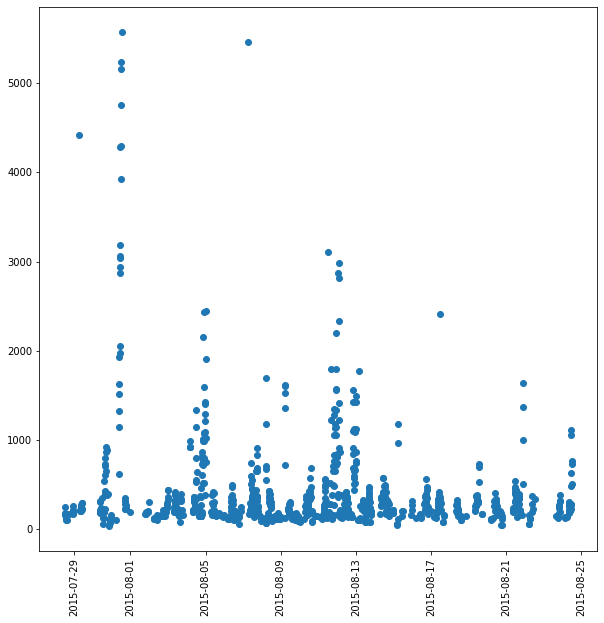

In [4]:
data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.tick_params(axis='x', rotation=90)

ax.plot_date(x=data.timestamp, y=data.value)

In [5]:
delta_df = pd.DataFrame({"delta":(data['timestamp']-data['timestamp'].shift())})
display(delta_df.head())
delta_df.describe()

,delta
0,NaT
1,0 days 00:10:00
2,0 days 00:19:00
3,0 days 01:31:00
4,0 days 00:10:00


,delta
count,999
mean,0 days 00:38:56.096096096
std,0 days 01:50:37.863001390
min,0 days 00:02:00
25%,0 days 00:10:00
50%,0 days 00:10:00
75%,0 days 00:21:00
max,1 days 03:11:00


## Using the smallest time step size (2 minutes), fill in the missing time steps with NaNs, and get an integer time step index.

In [6]:
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
time_step_size = "2min"

ref_date_range = pd.date_range(start_date, end_date, freq=time_step_size)
gaps = ref_date_range[~ref_date_range.isin(data["timestamp"])]
data_copy = copy.deepcopy(data)
data_copy.set_index('timestamp', inplace=True)
data_copy = data_copy.reindex(ref_date_range, fill_value=np.nan)

data_copy["xvalue"] = [i for i in range(len(data_copy))]

data_copy.head(15)

,value,xvalue
2015-07-28 11:56:00,248.0,0
2015-07-28 11:58:00,NaN,1
2015-07-28 12:00:00,NaN,2
2015-07-28 12:02:00,NaN,3
2015-07-28 12:04:00,NaN,4
2015-07-28 12:06:00,178.0,5
2015-07-28 12:08:00,NaN,6
2015-07-28 12:10:00,NaN,7
2015-07-28 12:12:00,NaN,8
2015-07-28 12:14:00,NaN,9


## Remove the NaNs since we have the integer time step indices that can reflect missing time steps.

In [7]:
indexed_data = data_copy[data_copy['value'].notnull()]
display(indexed_data.head())

,value,xvalue
2015-07-28 11:56:00,248.0,0
2015-07-28 12:06:00,178.0,5
2015-07-28 13:56:00,121.0,60
2015-07-28 14:06:00,103.0,65
2015-07-28 14:16:00,96.0,70


## Create the xs and ys for fitting.

In [8]:
my_xs = np.array(indexed_data.xvalue)
my_ys = np.array(indexed_data.value)

my_xs = [float(item) for item in my_xs]
my_ys = [float(item) for item in my_ys]
my_xs = np.array(my_xs)
my_ys = np.array(my_ys)
my_xs = np.reshape(my_xs, (len(my_xs),1))
my_ys = np.reshape(my_ys, (len(my_ys),1))

## Choose kernel

Note: Can also choose more intelligently by looking at your trend, seasonality, etc

If you have missing time steps, be careful how you construct your ACF.

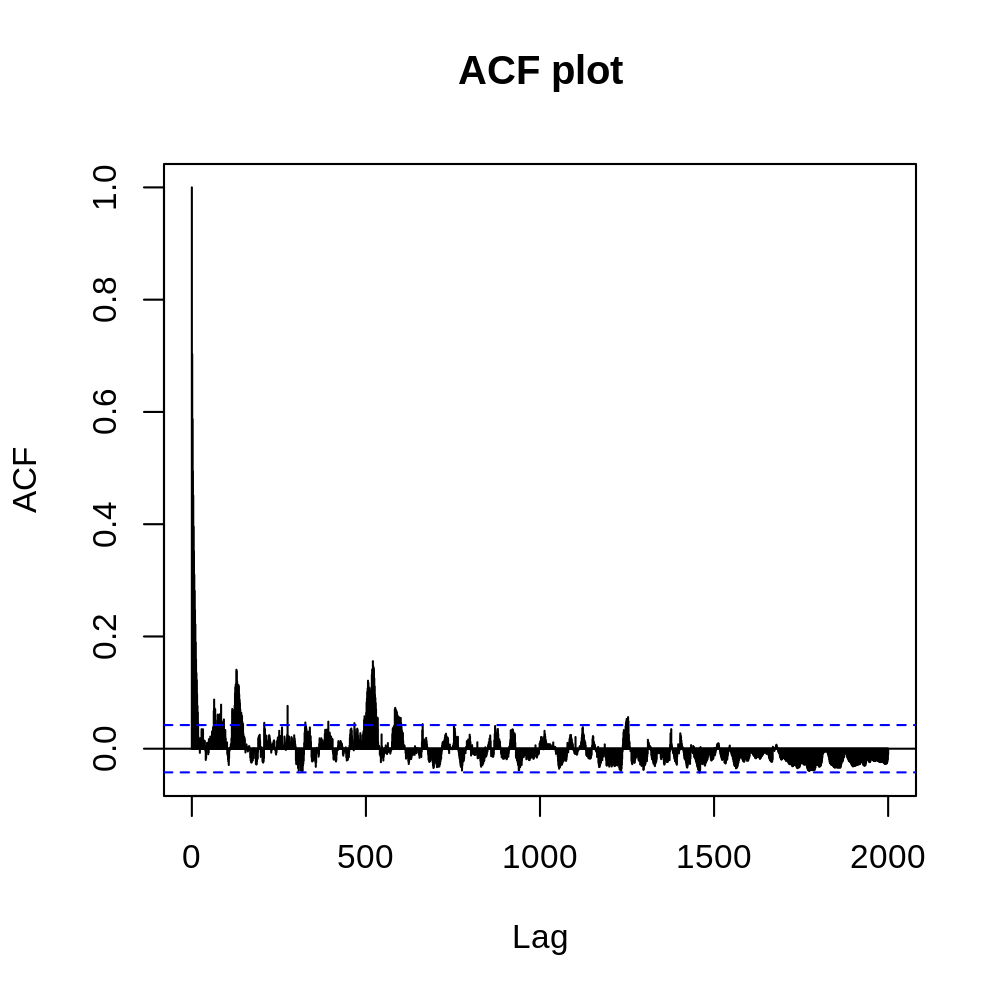

In [9]:
%%R -w 5 -h 5 --units in -r 200

data <- read.csv(file="data/TravelTime_451.csv", stringsAsFactors=FALSE)
acf(data$value,lag.max=2000, main="ACF plot", na.action=na.pass)

In [10]:
k1 = gpflow.kernels.Matern32() + gpflow.kernels.Linear() + gpflow.kernels.White()

## Train

In [11]:

f = gpflow.models.GPR((my_xs, my_ys), k1)
opt = gpflow.optimizers.Scipy()
opt.minimize(
    f.training_loss,
    f.trainable_variables,
    options=dict(maxiter=ci_niter(1000)),
    compile=True
)



## Predict

In [12]:
mean, var = f.predict_y(my_xs)

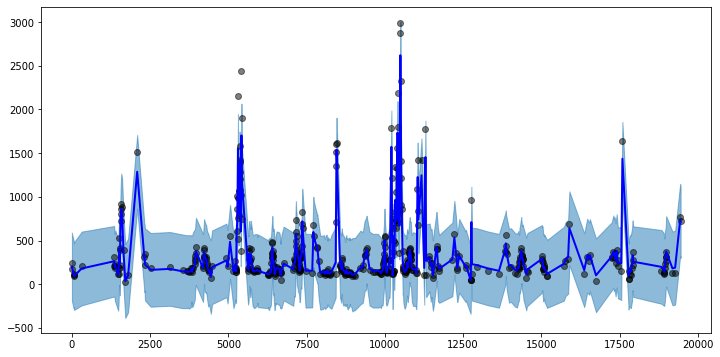

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(my_xs, my_ys, 'ko', mew=1, alpha=.5)
plt.plot(my_xs, mean,color="blue",lw=2)
plt.fill_between(my_xs[:,0],
                 mean[:,0] - 2*np.sqrt(var[:,0]),
                 mean[:,0] + 2*np.sqrt(var[:,0]),
                 color='C0', alpha=0.5)

# Sparse Gaussian Process (VFE)

In [14]:
np.random.seed(100)
Z = my_xs[np.random.permutation(len(my_xs))[:100]]

In [15]:

m = gpflow.models.SGPR((my_xs, my_ys), kernel=k1, inducing_variable=Z)
opt = gpflow.optimizers.Scipy()
opt.minimize(
    m.training_loss,
    m.trainable_variables,
    compile=True
)


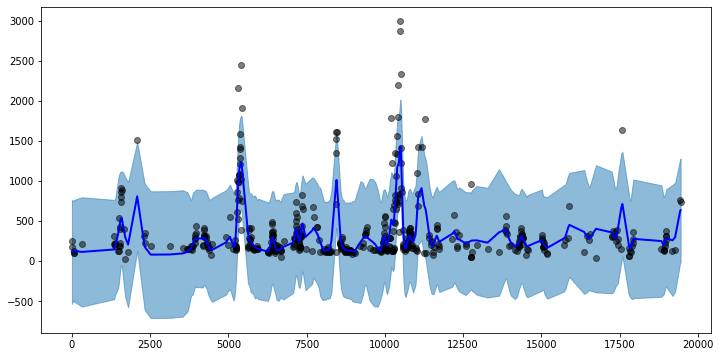

In [16]:
mean, var = m.predict_y(my_xs)

plt.figure(figsize=(12, 6))
plt.plot(my_xs, my_ys, 'ko', mew=1, alpha=.5)
plt.plot(my_xs, mean,color="blue",lw=2)
plt.fill_between(my_xs[:,0],
                 mean[:,0] - 2*np.sqrt(var[:,0]),
                 mean[:,0] + 2*np.sqrt(var[:,0]),
                 color='C0', alpha=0.5)

# Tidbits

1) Github page for gpflow

https://github.com/GPflow/GPflow

2) Paper on VFE SGP

http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf

3) Covarance functions reference

http://www.gaussianprocess.org/gpml/chapters/RW4.pdf

4) How do you choose your kernel?

http://www.cs.toronto.edu/~duvenaud/cookbook/index.html